In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [5]:
# Define dataset paths
data_dir = "./emotion"  # Modify path as needed
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# Set image properties
img_size = (48, 48)
batch_size = 64

# Data Augmentation and Normalization
train_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)

# Load images from directory
train_generator = train_data_gen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, color_mode='grayscale', class_mode='categorical'
)
test_generator = test_data_gen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, color_mode='grayscale', class_mode='categorical'
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [6]:
# CNN Model for Emotion Detection
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # 7 emotion categories
])

# Compile the Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display Model Summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 128)         0

In [7]:
# Define Early Stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the Model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=25,
    callbacks=[early_stop]
)


Epoch 1/25
449/449 [==============================] - 204s 449ms/step - loss: 1.7386 - accuracy: 0.2977 - val_loss: 1.5472 - val_accuracy: 0.4040
Epoch 2/25
449/449 [==============================] - 36s 79ms/step - loss: 1.5243 - accuracy: 0.4084 - val_loss: 1.3881 - val_accuracy: 0.4745
Epoch 3/25
449/449 [==============================] - 37s 81ms/step - loss: 1.4080 - accuracy: 0.4600 - val_loss: 1.3284 - val_accuracy: 0.4926
Epoch 4/25
449/449 [==============================] - 40s 89ms/step - loss: 1.3364 - accuracy: 0.4913 - val_loss: 1.2927 - val_accuracy: 0.5079
Epoch 5/25
449/449 [==============================] - 37s 83ms/step - loss: 1.2831 - accuracy: 0.5171 - val_loss: 1.2439 - val_accuracy: 0.5262
Epoch 6/25
449/449 [==============================] - 38s 85ms/step - loss: 1.2361 - accuracy: 0.5326 - val_loss: 1.2182 - val_accuracy: 0.5313
Epoch 7/25
449/449 [==============================] - 36s 81ms/step - loss: 1.1967 - accuracy: 0.5487 - val_loss: 1.2101 - val_accurac

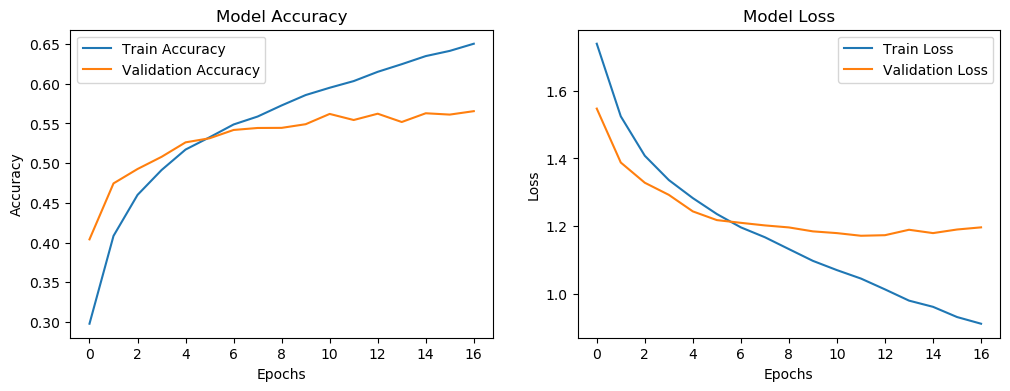

In [8]:
# Plot Accuracy and Loss Graphs
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.show()


In [9]:
# Save the trained model for future use
model.save("emotion_detection_cnn.h5")
print("Model saved successfully!")


/home/rhea/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully!


In [10]:
import cv2
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("emotion_detection_cnn.h5")

# Load OpenCV Haarcascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Define emotion categories
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Open webcam for real-time emotion detection
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        face = gray[y:y+h, x:x+w]
        face = cv2.resize(face, (48, 48))
        face = np.expand_dims(face, axis=0) / 255.0  # Normalize

        # Predict emotion
        prediction = model.predict(face)
        emotion = emotion_labels[np.argmax(prediction)]

        # Draw rectangle and label
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(frame, emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    cv2.imshow("Emotion Detection", frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 17ms/step


2025-03-28 12:54:34.577083: W tensorflow/core/data/root_dataset.cc:286] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 23ms/step
